<a href="https://colab.research.google.com/github/rll/deepul/blob/master/demos/lecture3_flow_models_demos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Getting Started
Go to **Runtime -> Change runtime type** and make sure **Hardward accelerator** is set to **GPU**

deepul/ .deepul/

In [2]:
import warnings
warnings.filterwarnings('ignore')

# Demo 1: Fitting a 1D Continuous Distribution
In this demo, we visualize how a flow can model a 1D distribution. We train a mixture model and use its CDF to transform x to z. If our mixture model has support everywhere (which it does if you use a mixture of Gaussians or Logistics), then the CDF is invertible.
- If we use the uniform as the base distribution, we're equivalently fitting a mixture of Gaussians via MLE.
- We can also use the Beta distribution as our base distribution. This works well when we use a CDF as our flow, since the codomain of the CDF is just $[0,1]$.

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import IPython
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim
from scipy.stats import norm
from tqdm import trange, tqdm_notebook
import deepul.pytorch_util as ptu
from deepul.demo2_helper import *

In [4]:
# setting colab to use gpu
# refer to deepul/pytorch_utils.py for more information on ptu
ptu.set_gpu_mode(True)
ptu.device

device(type='cuda', index=0)

## Initializing Hyperparameters and Visualizing Dataset

<Figure size 432x288 with 0 Axes>

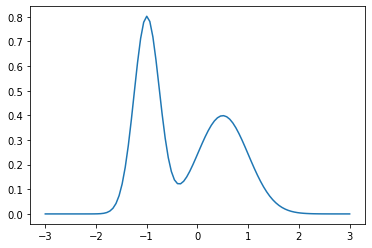

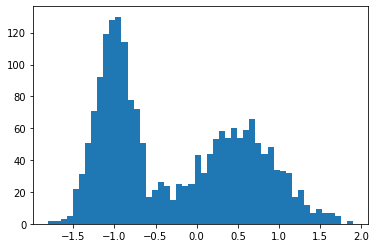

In [5]:
SEED = 10
np.random.seed(SEED)
torch.manual_seed(SEED)

n_train, n_test = 2000, 1000
loader_args = dict(batch_size=128, shuffle=True)
train_loader, test_loader = load_flow_demo_1(n_train, n_test, loader_args, visualize=True, train_only=False)

## Training Code
We optimize our models using gradient descent and minimize negative log-likelihood.

In [6]:
# applies gradient steps for each mini-batch in an epoch
def train(model, train_loader, optimizer):
    model.train()
    for x in train_loader:
        x = x.to(ptu.device).float()
        loss = model.nll(x)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

def eval_loss(model, data_loader):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for x in data_loader:
            x = x.to(ptu.device).float()
            loss = model.nll(x)
            total_loss += loss * x.shape[0]
        avg_loss = total_loss / len(data_loader.dataset)
    return avg_loss.item()

def train_epochs(model, train_loader, test_loader, train_args):
    # training parameters
    epochs, lr = train_args['epochs'], train_args['lr']
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # plotting parameters
    plot = train_args.get('plot', True)
    plot_frequency = train_args.get('plot_frequency', 5)
    if 'epochs_to_plot' in train_args.keys():
        plot_frequency = epochs + 1
        epochs_to_plot = train_args['epochs_to_plot']
    else:
        epochs_to_plot = []

    train_losses, test_losses = [], []
    for epoch in tqdm_notebook(range(epochs), desc='Epoch', leave=False):
        model.train()
        train(model, train_loader, optimizer)
        train_loss = eval_loss(model, train_loader)
        train_losses.append(train_loss)

        if test_loader is not None:
            test_loss = eval_loss(model, test_loader)
            test_losses.append(test_loss)

        if plot and (epoch % plot_frequency == 0 or epoch in epochs_to_plot):
            model.plot(f'Epoch {epoch}')
            
    if plot:
        plot_train_curves(epochs, train_losses, test_losses, title='Training Curve')
    return train_losses, test_losses

## Model: CDF Mixture Model


In [7]:
import copy
from torch.distributions.uniform import Uniform
from torch.distributions.beta import Beta
from torch.distributions.normal import Normal
from scipy.optimize import bisect

class MixtureCDFFlow(nn.Module):
    def __init__(self, 
                 base_dist='uniform', 
                 mixture_dist='gaussian',
                 n_components=4,
                 plot_bounds=(-3,3)):
        super().__init__()
        self.composition = False
        if base_dist == 'uniform':
            self.base_dist = Uniform(ptu.FloatTensor([0.0]), ptu.FloatTensor([1.0]))
        elif base_dist == 'beta':
            self.base_dist = Beta(ptu.FloatTensor([5.0]), ptu.FloatTensor([5.0])) 
        else:
            raise NotImplementedError

        self.loc = nn.Parameter(ptu.randn(n_components), requires_grad=True)
        self.log_scale = nn.Parameter(ptu.zeros(n_components), requires_grad=True)
        self.weight_logits = nn.Parameter(ptu.zeros(n_components), requires_grad=True)
        if mixture_dist == 'gaussian':
            self.mixture_dist = Normal 
        self.n_components = n_components
        self.plot_bounds = plot_bounds

    def flow(self, x):
        # set up mixture distribution
        weights = F.softmax(self.weight_logits, dim=0).unsqueeze(0).repeat(x.shape[0], 1)
        mixture_dist = self.mixture_dist(self.loc, self.log_scale.exp())
        x_repeat = x.unsqueeze(1).repeat(1, self.n_components)

        # z = cdf of x
        z = (mixture_dist.cdf(x_repeat) * weights).sum(dim=1)

        # log_det = log dz/dx = log pdf(x)
        log_det = (mixture_dist.log_prob(x_repeat).exp() * weights).sum(dim=1).log()

        return z, log_det

    def invert(self, z):
        # Find the exact x via bisection such that f(x) = z
        results = []
        for z_elem in z:
            def f(x):
                return self.flow(torch.tensor(x).unsqueeze(0))[0] - z_elem
            x = bisect(f, -20, 20)
            results.append(x)
        return torch.tensor(results).reshape(z.shape)

    def log_prob(self, x):
        z, log_det = self.flow(x)
        return self.base_dist.log_prob(z) + log_det
 
    # Compute loss as negative log-likelihood
    def nll(self, x):
        return - self.log_prob(x).mean()
        
    def get_density(self):
        x = np.linspace(self.plot_bounds[0], self.plot_bounds[1], 1000)
        with torch.no_grad():
            y = self.log_prob(ptu.FloatTensor(x)).exp().cpu().numpy()
        return x, y

    def plot(self, title):
        density = self.get_density()
        plt.figure()
        plt.plot(density[0], density[1])
        plt.title(title)

## Training with Uniform base distribution


/disk2/chenting/anaconda3/envs/torch_1/lib/python3.6/site-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


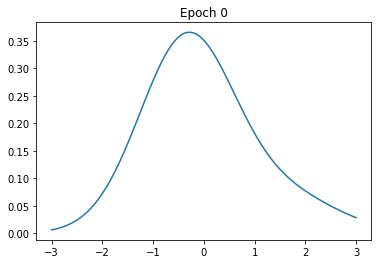

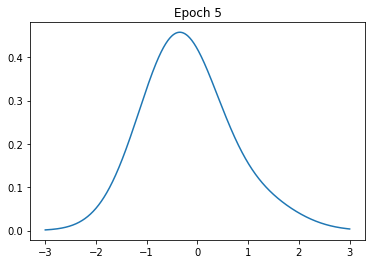

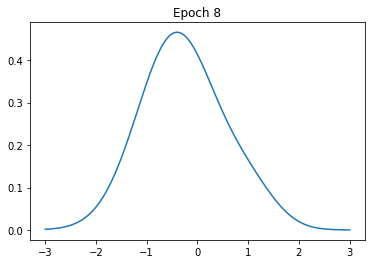

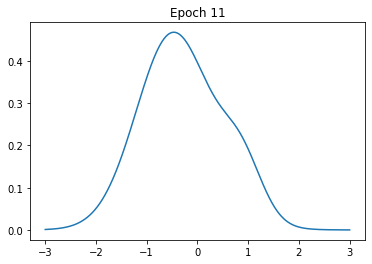

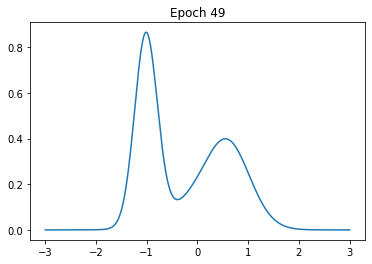

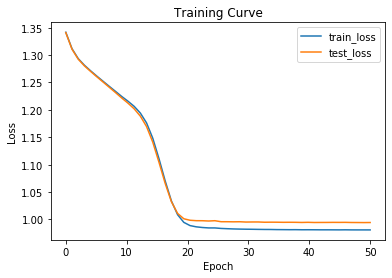

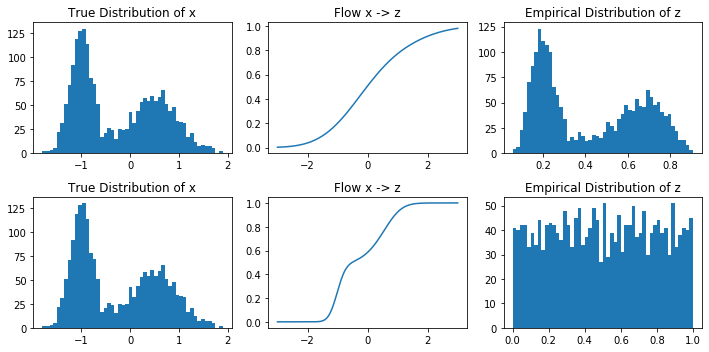

In [8]:
cdf_flow_model = MixtureCDFFlow(base_dist='uniform', mixture_dist='gaussian', n_components=5).to(ptu.device)
cdf_flow_model_old = copy.deepcopy(cdf_flow_model)
train_epochs(cdf_flow_model, train_loader, test_loader, dict(epochs=50, lr=5e-3, epochs_to_plot=[0,5,8,11,49]))
visualize_demo1_flow(train_loader, cdf_flow_model_old, cdf_flow_model)

This figure shows us how our flow changes over training, from initialization (top row) to convergence (bottom row).
- Left column: the distribution of our training points. 
- Middle column: our invertible flow. 
- Right column: the distribution of $\{f(x): x \in \mathcal{X}\}$. 

After training, note how the transformed points "cover" the base distribution as much as possible, in order to maximize their probabilities. 

## Training with Beta(5, 5) base distribution

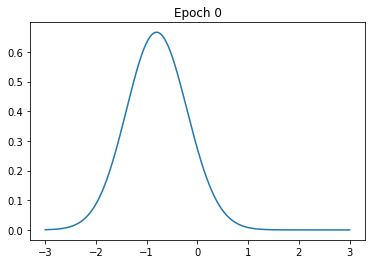

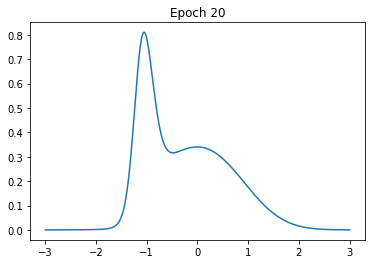

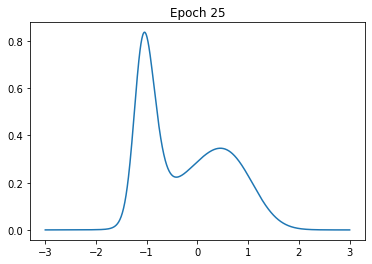

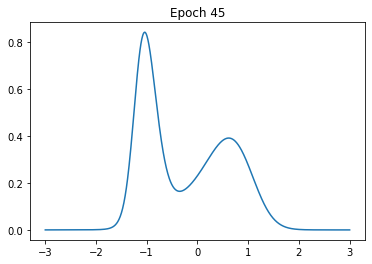

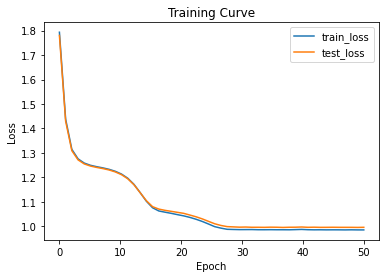

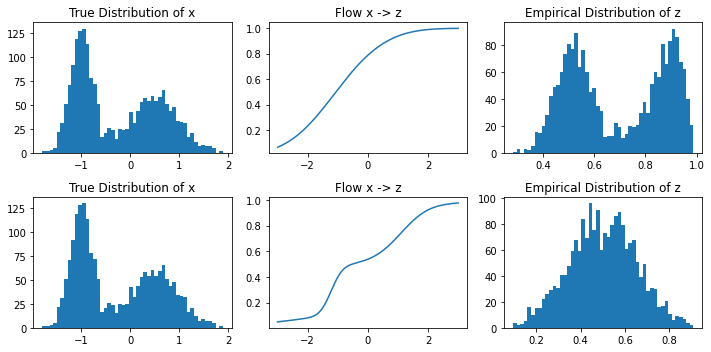

In [0]:
beta_cdf_flow_model = MixtureCDFFlow(base_dist='beta', mixture_dist='gaussian', n_components=5)
beta_cdf_flow_model_old = copy.deepcopy(beta_cdf_flow_model)
train_epochs(beta_cdf_flow_model, train_loader, test_loader, dict(epochs=50, lr=1e-2, epochs_to_plot=[0, 20, 25,45]))
visualize_demo1_flow(train_loader, beta_cdf_flow_model_old, beta_cdf_flow_model)

Note that the transformed points $z$ have a different resulting distribution, since they're trying to "cover" a different base distribution.

# Demo 2: Composing Flows Increases Expressivity
It's intuitive that a single CDF flow may not have enough capacity to model an entire distribution. For example, we may fruitlessly try to fit a mixture of 10 Gaussians using a model with only 5. 

It turns out that we can compose the invertible flows and retain all of their nice properties: easy sampling and exact log-likelihood calculation. Here we ask: can we compose simpler flows to produce a complex one that can better fit a target distribution? This is quite similar to deep neural networks, where adding layers allows us to build rich representations and complex models. 


## Model: Logit Transform
A mixture of Gaussians CDF flow maps real-valued data into the unit interval $[0, 1]$. If we want to compose these flows, we need to add a "nonlinearity" that spreads mass from $[0, 1]$ back across the real numbers. Similar to how ReLUs help neural networks form complex, nonlinear functions, this "nonlinearity" can help a stack of flows model something much more complicated.

Here, we use the logit transform, which can be expressed symbolically as:
$$f(x) = \text{logit}(\alpha/2 + (1-\alpha)x)$$
where logit is the inverse of the sigmoid function. $\alpha$ controls how much this function spreads the mass back out. $\alpha=0$ spreads $[0, 1] \rightarrow \mathbb{R}$, while $\alpha = 1$ maps $[0, 1]\rightarrow \{0\}$. 

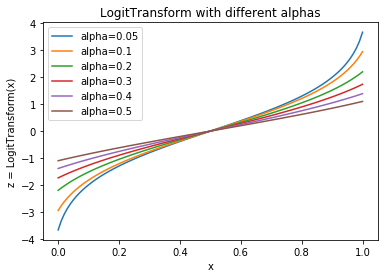

In [9]:
class LogitTransform(nn.Module):
    def __init__(self, alpha=0.1): 
        super().__init__()
        self.alpha = alpha
  
    def forward(self, x): 
        x_new = self.alpha/2 + (1-self.alpha) * x
        return torch.log(x_new) - torch.log(1-x_new), torch.log(ptu.FloatTensor([1-self.alpha])) - torch.log(x_new) - torch.log(1-x_new)

    def flow(self, x, cond=None):
        return self.forward(x)

    def invert(self, z, cond=None):
        x_new = torch.sigmoid(z)
        return (x_new - self.alpha/2) / (1-self.alpha)

# visualization code for what LogitTransform does
alphas = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
transforms = [LogitTransform(alpha=a).to(ptu.device) for a in alphas]
xs = ptu.FloatTensor(np.linspace(0, 1, 100))
ys = [ptu.get_numpy(transform.flow(xs)[0]) for transform in transforms]
xs = ptu.get_numpy(xs)
for y, alpha in zip(ys, alphas):
    plt.plot(xs, y, label=f'alpha={alpha}')
plt.xlabel('x')
plt.ylabel('z = LogitTransform(x)')
plt.title('LogitTransform with different alphas')
plt.legend()
plt.show()

## Model: Composition of 1D Flows

In [10]:
class CompositionOfFlows(nn.Module):
    def __init__(self, flows):
        super().__init__()
        self.flows = nn.ModuleList(flows)

    def flow(self, x):
        z, log_det = x, 0
        for flow_module in self.flows:
            z, next_log_det = flow_module.flow(z)
            log_det += next_log_det
        return z, log_det

    def log_prob(self, x):
        z, log_det = self.flow(x)
        return self.flows[-1].base_dist.log_prob(z) + log_det

    def invert(self, z):
        for flow_module in reversed(self.flows):
            z = flow_module.invert(z)
        return z
 
    # Compute loss as negative log-likelihood
    def nll(self, x):
        return - self.log_prob(x).mean()
        
    def get_density(self):
        x = np.linspace(-3, 3, 1000)
        with torch.no_grad():
            y = ptu.get_numpy(self.log_prob(ptu.FloatTensor(x)).exp())
        return x, y
    
    def plot(self, title):
        density = self.get_density()
        plt.figure()
        plt.plot(density[0], density[1])
        plt.title(title)

## Training: Bimodal gaussian
We can test this composition of flows on the same bimodal gaussian from Demo 1. Let's see how well it does. 

<Figure size 432x288 with 0 Axes>

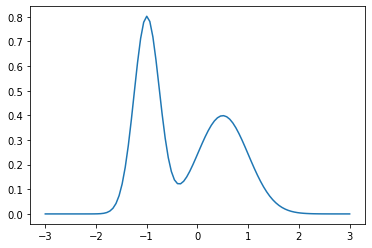

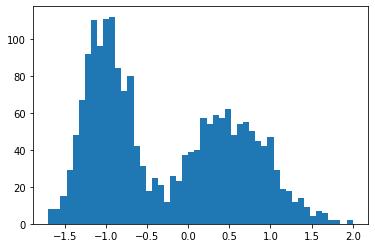

In [11]:
n_train, n_test = 2000, 1000
loader_args = dict(batch_size=128, shuffle=True)
train_loader, test_loader = load_flow_demo_1(n_train, n_test, loader_args, visualize=True, train_only=False)

/disk2/chenting/anaconda3/envs/torch_1/lib/python3.6/site-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


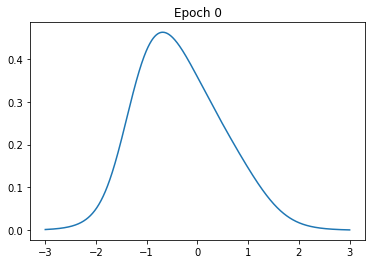

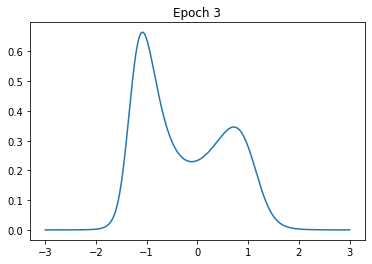

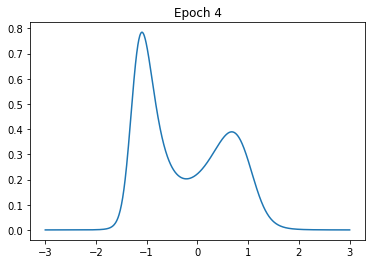

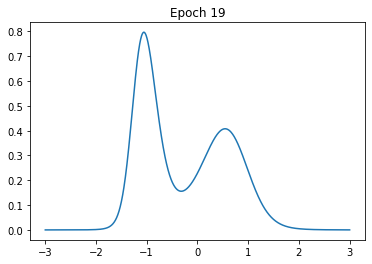

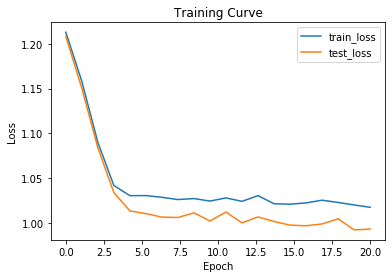

In [12]:
composed_model = CompositionOfFlows([MixtureCDFFlow(n_components=5),
                                     LogitTransform(alpha=0.1),
                                     MixtureCDFFlow(n_components=5),
                                     LogitTransform(alpha=0.1),
                                     MixtureCDFFlow(n_components=5)]).to(ptu.device)
train_losses, test_losses = train_epochs(composed_model, train_loader, test_loader, dict(epochs=20, lr=1e-2, plot=True, epochs_to_plot=[0, 3, 4, 19]))

The model learns quite fast, but doesn't get better test loss than a single CDF flow. This is because a single CDF flow with 2 mixture elements can perfectly model this distribution. Below, we can visualize how the test loss varies when we change the number of layers (aka the number of individual CDF flows that we use), or the number of elements in each layers (aka the number of mixture elements in each CDF, which is akin to the "width" of a normal deep neural network).

In [13]:
def calculate_sweep_losses(train_loader, test_loader, n_epochs=100, n_seeds=3):
    losses = np.zeros([5, 5])
    seeds = list(range(10, 10 * (n_seeds + 1), 10))
    for n_components in range(1, 6):
        for n_layers in range(1, 6):
            print(n_components, n_layers)
            for seed in seeds:
                np.random.seed(seed)
                torch.manual_seed(seed)
                components = []
                for _ in range(n_layers):
                    components += [MixtureCDFFlow(n_components=n_components), LogitTransform(alpha=0.1)]
                components.pop()
                composed_model = CompositionOfFlows(components).to(ptu.device)
                train_losses, test_losses = train_epochs(composed_model, train_loader, test_loader, dict(epochs=n_epochs, lr=1e-2, plot=False))
                losses[n_layers - 1, n_components - 1] += test_losses[-1]
    return losses / len(seeds)

1 1


/disk2/chenting/anaconda3/envs/torch_1/lib/python3.6/site-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


1 2


1 3


1 4


1 5


2 1


2 2


2 3


2 4


2 5


3 1


3 2


3 3


3 4


3 5


4 1


4 2


4 3


4 4


4 5


5 1


5 2


5 3


5 4


5 5


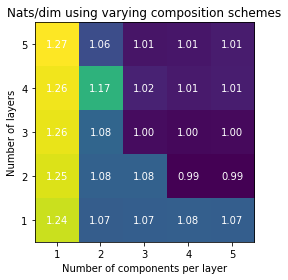

In [14]:
bimodal_losses = calculate_sweep_losses(train_loader, test_loader, n_epochs=20)
plot_demo2_losses(bimodal_losses)

This figure shows that we can achieve the best possible nats/dim performance possible once we have two Gaussians in a single layer. No matter how much we increase the model capacity beyond that point, the test loss doesn't decrease any further -- since the true data distribution has already been captured. 

## Training: Uniform

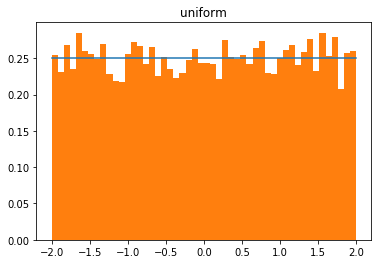

In [15]:
n_train, n_test = 10000, 2000
loader_args = dict(batch_size=128, shuffle=True)
uniform_train_loader, uniform_test_loader = load_flow_demo_2(n_train, n_test, loader_args, distribution='uniform')

/disk2/chenting/anaconda3/envs/torch_1/lib/python3.6/site-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


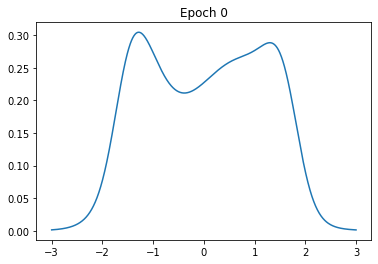

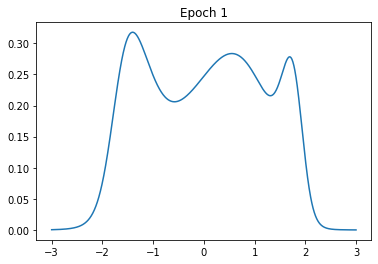

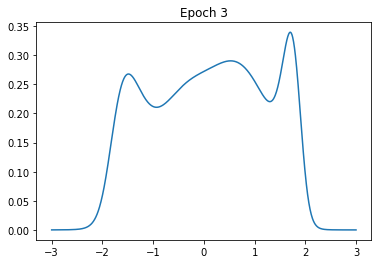

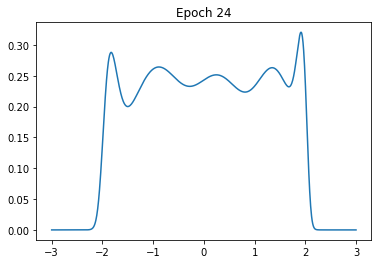

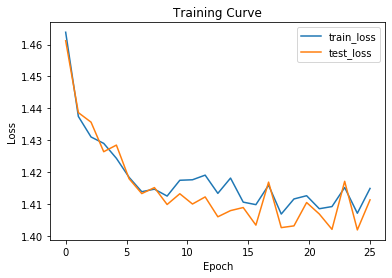

In [16]:
composed_model = CompositionOfFlows([MixtureCDFFlow(n_components=5),
                                     LogitTransform(alpha=0.1),
                                     MixtureCDFFlow(n_components=5),
                                     LogitTransform(alpha=0.1),
                                     MixtureCDFFlow(n_components=5)]).to(ptu.device)
train_losses, test_losses = train_epochs(composed_model, uniform_train_loader, uniform_test_loader, dict(epochs=25, lr=1e-2, plot=True, epochs_to_plot=[0, 1, 3, 24]))

In [ ]:
uniform_losses = calculate_sweep_losses(uniform_train_loader, uniform_test_loader, n_epochs=25)
plot_demo2_losses(uniform_losses)

1 1


/disk2/chenting/anaconda3/envs/torch_1/lib/python3.6/site-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


1 2


1 3


1 4


1 5


2 1


2 2


2 3


2 4


2 5


A uniform distribution has sharp edges at $x=0$ and $x=1$ that can't be perfectly modeled by a Gaussian mixture model with any number of components. Thus, increasing model capacity should lead to better model fit. This figure shows an interesting phenonenon that results. As we increase the depth or the width of the flow, the test loss continually decreases.

## Training: Complicated distribution

In [ ]:
n_train, n_test = 10000, 5000
loader_args = dict(batch_size=128, shuffle=True)
complicated_train_loader, complicated_test_loader = load_flow_demo_2(n_train, n_test, loader_args, distribution='complex')

In [ ]:
composed_model = CompositionOfFlows([MixtureCDFFlow(n_components=5),
                                     LogitTransform(alpha=0.1),
                                     MixtureCDFFlow(n_components=5),
                                     LogitTransform(alpha=0.1),
                                     MixtureCDFFlow(n_components=5)]).to(ptu.device)
train_losses, test_losses = train_epochs(composed_model, complicated_train_loader, complicated_test_loader, dict(epochs=50, lr=1e-2, plot=True, epochs_to_plot=[0, 1, 3, 19]))

In [ ]:
complicated_losses = calculate_sweep_losses(complicated_train_loader, complicated_test_loader, n_epochs=20)
plot_demo2_losses(complicated_losses)

# Demo 3: Learning 2D Distributions with Autoregressive Flows

## Models


In [ ]:
# classic multi-layer perceptron
class MLP(nn.Module):
    def __init__(self, input_size, n_hidden, hidden_size, output_size):
        super().__init__()
        layers = []
        for _ in range(n_hidden):
            layers.append(nn.Linear(input_size, hidden_size))
            layers.append(nn.ReLU())
            input_size = hidden_size
        layers.append(nn.Linear(hidden_size, output_size))
        self.layers = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.layers(x)

# same CDF flow as in Demo 1, but conditioned on an auxillary variable
class ConditionalMixtureCDFFlow(nn.Module):
    def __init__(self, 
                 base_dist='uniform', 
                 mixture_dist='gaussian',
                 n_components=4,
                 n_layers=3, 
                 hidden_size=64,
                 cond_dim=1):
        super().__init__()
        self.mlp = MLP(cond_dim, n_layers, hidden_size, n_components * 3)
        if mixture_dist == 'gaussian':
            self.mixture_dist = Normal # (self.loc, self.log_scale.exp())
        elif mixture_dist == 'logistic':
            self.mixture_dist = Logistic
        self.n_components = n_components

    def flow(self, x, cond):
        # parameters of flow on x depend on what it's conditioned on 
        loc, log_scale, weight_logits = torch.chunk(self.mlp(cond), 3, dim=1)
        weights = F.softmax(weight_logits)

        # z = cdf(x)
        z = (self.mixture_dist(loc, log_scale.exp()).cdf(x.repeat(1, self.n_components)) * weights).sum(dim=1)

        # log_det = log dz/dx = log pdf(x)
        log_det = (self.mixture_dist(loc, log_scale.exp()).log_prob(x.repeat(1, self.n_components)).exp() * weights).sum(dim=1).log()

        return z, log_det

    def invert(self, z, cond):
        # Find the exact x via bisection such that f(x) = z
        results = []
        for z_elem in z:
            def f(x):
                return self.flow(torch.tensor(x).unsqueeze(0))[0] - z_elem
            x = bisect(f, -20, 20)
            results.append(x)
        return torch.tensor(results).reshape(z.shape)

    def log_prob(self, x):
        z, log_det = self.flow(x)
        return self.base_dist.log_prob(z) + log_det

class AutoregressiveFlow(nn.Module):
    """
    Assumes that we're modeling a 2D distribution
    """
    def __init__(self, 
                 dataset,
                 dataset_name,
                 train_labels,
                 dim1_mixture_dist='gaussian', 
                 dim1_n_components=5, 
                 dim2_mixture_dist='gaussian', 
                 dim2_n_components=5,
                 mlp_hidden_size=64,
                 mlp_n_layers=3):
        super().__init__()
        self.dataset = ptu.FloatTensor(dataset)
        self.dataset_name = dataset_name
        self.train_labels = train_labels
        self.dim1_flow = MixtureCDFFlow(mixture_dist=dim1_mixture_dist, n_components=dim1_n_components)
        self.dim2_flow = ConditionalMixtureCDFFlow(n_components=dim2_n_components,
                 n_layers=mlp_n_layers, 
                 hidden_size=mlp_hidden_size,
                 cond_dim=1)
        self.dim2_n_components = dim2_n_components
        self.base_dist = Uniform(ptu.tensor(0.0), ptu.tensor(1.0))
        if dim2_mixture_dist == 'gaussian':
            self.mixture_dist = Normal
        elif dim2_mixture_dist == 'logistic':
            raise NotImplementedError

    def flow(self, x):
        # individually flow on each dim
        x1, x2 = torch.chunk(x, 2, dim=1)
        z1, log_det1 = self.dim1_flow.flow(x1.squeeze())
        z2, log_det2 = self.dim2_flow.flow(x2, cond=x1)
        return torch.cat([z1.unsqueeze(1), z2.unsqueeze(1)], dim=1), torch.cat([log_det1.unsqueeze(1), log_det2.unsqueeze(1)], dim=1)

    def log_prob(self, x):
        z, log_det = self.flow(x)
        return (self.base_dist.log_prob(z) + log_det).sum(dim=1) # shape: [batch_size, dim]

    def nll(self, x):
        return - self.log_prob(x).mean()

    def plot(self, title):
        plt.figure(figsize=(10,5))

        # latent space
        plt.subplot(121)
        z, _ = self.flow(self.dataset)
        z = ptu.get_numpy(z)
        plt.scatter(z[:, 0], z[:, 1], s=1.5, c=self.train_labels)
        plt.title(title + " Latent Space")
        
        # density plot
        plt.subplot(122)
        dx, dy = 0.025, 0.025
        if self.dataset_name == 'moons':
            x_lim = (-1.5, 2.5)
            y_lim = (-1, 1.5)
        elif self.dataset_name == 'face':
            x_lim = (-4, 4)
            y_lim = (-4, 4)
        y, x = np.mgrid[slice(y_lim[0], y_lim[1] + dy, dy),
                        slice(x_lim[0], x_lim[1] + dx, dx)]
        mesh_xs = ptu.FloatTensor(np.stack([x, y], axis=2).reshape(-1, 2))
        densities = np.exp(ptu.get_numpy(self.log_prob(mesh_xs)))
        plt.pcolor(x, y, densities.reshape([y.shape[0], y.shape[1]]))
        plt.title(title + " Densities")
        plt.tight_layout()

## Training: Two Moons


In [ ]:
n_train = 2000
n_test = 1000
loader_args = dict(batch_size=128, shuffle=True)
train_loader, test_loader, train_labels, test_labels = load_flow_demo_3(n_train, n_test, loader_args, visualize=True, train_only=False, distribution='moons')

In [ ]:
ar_flow = AutoregressiveFlow(train_loader.dataset, 'moons', train_labels) 
train_losses, test_losses = train_epochs(ar_flow, train_loader, test_loader, dict(epochs=100, lr=5e-3, epochs_to_plot=[0, 1, 3, 6, 10, 99]))

## Training: Face

In [ ]:
n_train = 2000
n_test = 1000
loader_args = dict(batch_size=128, shuffle=True)
train_loader, test_loader, train_labels, test_labels = load_flow_demo_3(n_train, n_test, loader_args, visualize=True, train_only=False, distribution='face')

In [ ]:
ar_flow = AutoregressiveFlow(train_loader.dataset, 'face', train_labels)
train_losses, test_losses = train_epochs(ar_flow, train_loader, test_loader, dict(epochs=100, lr=5e-3, epochs_to_plot=[0, 1, 3, 6, 10, 99]))

# Demo 4: Parameter Sharing for Flows

We've seen that flows can be used to learn a density model over data in multiple dimensions. But what happens if we try learning a model over, say, a 32x32 image? A naive approach, building off of the method used in Demo 3, would be to use a separate MLP to learn each conditional flow $z_i = f(x_i | x_1, \dots, x_{i-1})$. However, this is incredibly inefficient. For the aforementioned 32x32 image, we'd have to learn 1024 separate networks. This would have way too many parameters to train with a reasonably-sized dataset. 

However, we can borrow ideas from autoregressive models -- parameter sharing! Instead of learning a separate model for each dimension, we can use masking to simultaneously learn every flow with a single model. Here, we explore an autoregressive flow, using a PixelCNN-style masking scheme to respect the variable ordering.  

## Visualizing Dataset

In [ ]:
visualize_demo4_data()

## New Training Code
We need to slightly modify the training code that we introduced back in Demo 1. Now, we need to dequantize the data (see Demo 7 for an explanation of what this means) for every new batch, so we add a line to add uniform noise to each minibatch.


In [ ]:
def train_with_dequantization_demo4(model, train_loader, optimizer):
    model.train()
    losses = []
    for x in train_loader:
        x = x.to(ptu.device).float().contiguous()
        x += torch.distributions.Uniform(0.0, 0.25).sample(x.shape).to(ptu.device)
        loss = model.nll(x)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
    return losses

def train_epochs_demo4(model, train_loader, test_loader, train_args):
    epochs, lr = train_args['epochs'], train_args['lr']
    optimizer = optim.Adam(model.parameters(), lr=lr)

    train_losses, test_losses = [], []
    test_loss = eval_loss(model, test_loader)
    test_losses.append(test_loss)  # loss at init
    for epoch in tqdm_notebook(range(epochs), desc='Epoch', leave=False):
        model.train()
        epoch_train_losses = train_with_dequantization_demo4(model, train_loader, optimizer) 
        train_losses.extend(epoch_train_losses)

        test_loss = eval_loss(model, test_loader)
        test_losses.append(test_loss)
            
    return train_losses, test_losses

## Models
This code will look very similar to the PixelCNN code from the autoregressive models code, with one main difference. Instead of outputting logits for each pixel, we output the parameters of a mixture model CDF flow for each pixel.

In [ ]:
class MaskConv2d(nn.Conv2d):
  def __init__(self, mask_type, *args, **kwargs):
    assert mask_type == 'A' or mask_type == 'B'
    super().__init__(*args, **kwargs)
    self.register_buffer('mask', torch.zeros_like(self.weight))
    self.create_mask(mask_type)

  def forward(self, input, cond=None):
    batch_size = input.shape[0]
    out = F.conv2d(input, self.weight * self.mask, self.bias, self.stride,
                   self.padding, self.dilation, self.groups)
    return out

  def create_mask(self, mask_type):
    k = self.kernel_size[0]
    self.mask[:, :, :k // 2] = 1
    self.mask[:, :, k // 2, :k // 2] = 1
    if mask_type == 'B':
      self.mask[:, :, k // 2, k // 2] = 1

class LayerNorm(nn.LayerNorm):
  def __init__(self, *args, **kwargs):
    super().__init__(*args, **kwargs)

  def forward(self, x):
    x = x.permute(0, 2, 3, 1).contiguous()
    x_shape = x.shape
    x = super().forward(x)
    return x.permute(0, 3, 1, 2).contiguous()

class AutoregressiveFlowPixelCNN(nn.Module):
  def __init__(self, input_shape, n_filters=64,
               kernel_size=7, n_layers=5, 
               n_components=2, **kwargs):
    super().__init__()
    assert n_layers >= 2
    n_channels = input_shape[0]

    block_init = lambda: MaskConv2d('B', n_filters, n_filters, 
                                    kernel_size=kernel_size,
                                    padding=kernel_size // 2, **kwargs)
    
    model = nn.ModuleList([MaskConv2d('A', n_channels, n_filters, 
                                      kernel_size=kernel_size,
                                      padding=kernel_size // 2, **kwargs)])
    for _ in range(n_layers):
      model.append(LayerNorm(n_filters))
      model.extend([nn.ReLU(), block_init()])
    model.extend([nn.ReLU(), MaskConv2d('B', n_filters, n_filters, 1, **kwargs)])
    model.extend([nn.ReLU(), MaskConv2d('B', n_filters, n_components * 3 * n_channels, 1, **kwargs)])

    self.net = model
    self.input_shape = input_shape
    self.n_channels = n_channels
    self.n_components = n_components

  def forward(self, x, cond=None):
    batch_size = x.shape[0]
    out = x.float()
    for layer in self.net:
      if isinstance(layer, MaskConv2d):
        out = layer(out, cond=cond)
      else:
        out = layer(out)
    return out.view(batch_size, 3 * self.n_components, *self.input_shape) 

  def nll(self, x, cond=None):
    loc, log_scale, weight_logits = torch.chunk(self.forward(x), 3, dim=1)
    weights = F.softmax(weight_logits, dim=1) #.repeat(1, 1, self.n_components, 1, 1)
    log_det_jacobian = Normal(loc, log_scale.exp()).log_prob(x.unsqueeze(1).repeat(1,1,self.n_components,1,1))
    return -log_det_jacobian.mean()

  def sample(self, n, cond=None):
    samples = torch.zeros(n, *self.input_shape).cuda()
    with torch.no_grad():
      for r in range(self.input_shape[1]):
        for c in range(self.input_shape[2]):
          for k in range(self.n_channels):
            loc, log_scale, weight_logits = torch.chunk(self.forward(samples), 3, dim=1)
            loc, log_scale, weight_logits = loc[:,:,k,r,c], log_scale[:,:,k,r,c], weight_logits[:,:,k,r,c]
            probs = F.softmax(weight_logits, dim=1)
            chosen_centers = torch.multinomial(probs, 1).squeeze(-1)
            samples[:, k, r, c] = torch.normal(loc[torch.arange(n), chosen_centers], log_scale[torch.arange(n), chosen_centers].exp())
    return ptu.get_numpy(samples.permute(0, 2, 3, 1))

In [ ]:
def demo4(train_data, test_data):
  train_data = np.transpose(train_data, (0, 3, 1, 2)).astype(np.float32) / 2.0
  test_data = np.transpose(test_data, (0, 3, 1, 2)).astype(np.float32) / 2.0
  test_data = test_data + np.random.uniform(high=0.25, size=test_data.shape)

  H, W = 20, 20
  model = AutoregressiveFlowPixelCNN((1, H, W), n_layers=5, n_components=10).to(ptu.device)

  train_loader = data.DataLoader(train_data, batch_size=128, shuffle=True)
  test_loader = data.DataLoader(test_data, batch_size=128)
  train_losses, test_losses = train_epochs_demo4(model, train_loader, test_loader, 
                                           dict(epochs=20, lr=1e-3))
  samples = model.sample(100) 
  floored_samples = samples.copy()
  floored_samples[samples < 0.375] = 0.0
  floored_samples[samples >= 0.375] = 1.0

  # add log(4) = -log(0.25) to correct nll for fact that a bin of width 0.25 represents one value
  return train_losses + np.log(4), test_losses + np.log(4), samples, floored_samples

In [ ]:
demo4_save_results(demo4)

# Demo 5: Composing Flows in Multiple Dimensions
We can learn the same 2D distributions from Demo #3 using a composition of flows. However, instead of relying on the mixture CDF flows that we saw in Demos 1-4, we can use a different type of flow: a conditional affine transformation. Specifically, if we have 2-dimensional data $x$, then the flow would result in 
$$z_1 = x_1$$
$$z_2 = \text{shift}(x_1) + \text{scale}(x_1) \times x_2$$
where $\text{shift}(x_1)$ and $\text{scale}(x_1)$ are MLPs that take $x_1$ as input, and output a single real-valued number. After applying this transformation, we can then apply the complementary transformation, with 
$$z_1 = \text{shift}(x_2) + \text{scale}(x_2) \times x_1$$
$$z_2= x_2$$

Now, let's talk about why we would want to do this. Note that the log-likelihood of any data point $x$ is:
$$\log p_\theta(x) = p(z) + log |\frac{dz}{dx}|$$
When we use this specific conditional affine transformation, the Jacobian (the term on the left) is triangular, so the log-determinant term is easy to calculate. Specifically, the log-determinant will always just be $\log \text{scale}$.
Note that we still need this to be an invertible transformation. To ensure that the scale is never zero, we enforce that scale is always strictly positive by having 
$$\text{scale}(x_1) = \exp\{\text{MLP}(x_1)\}$$

## Models: RealNVP


In [ ]:
class AffineTransform(nn.Module):
    def __init__(self, type, n_hidden=2, hidden_size=256):
        super().__init__()
        self.mask = self.build_mask(type=type)
        self.scale = nn.Parameter(torch.zeros(1), requires_grad=True)
        self.scale_shift = nn.Parameter(torch.zeros(1), requires_grad=True)
        self.mlp = MLP(input_size=2, n_hidden=n_hidden, hidden_size=hidden_size, output_size=2)

    def build_mask(self, type):
        # if type == "left", left half is a one
        # if type == right", right half is a one
        assert type in {"left", "right"}
        if type == "left":
            mask = ptu.FloatTensor([1.0, 0.0])
        elif type == "right":
            mask = ptu.FloatTensor([0.0, 1.0])
        else:
            raise NotImplementedError
        return mask

    def forward(self, x, reverse=False):
        # returns transform(x), log_det
        batch_size = x.shape[0]
        mask = self.mask.repeat(batch_size, 1)
        x_ = x * mask

        log_s, t = self.mlp(x_).split(1, dim=1) 
        log_s = self.scale * torch.tanh(log_s) + self.scale_shift
        t = t * (1.0 - mask)
        log_s = log_s * (1.0 - mask)

        if reverse:  # inverting the transformation
            x = (x - t) * torch.exp(-log_s)
        else:
            x = x * torch.exp(log_s) + t
        return x, log_s

class RealNVP(nn.Module):
    def __init__(self, 
                 transforms, 
                 dataset,
                 dataset_name,
                 train_labels,):
        super().__init__()

        self.prior = torch.distributions.Normal(torch.tensor(0.).to(ptu.device), torch.tensor(1.).to(ptu.device))
        self.transforms = nn.ModuleList(transforms)
        self.dataset = ptu.FloatTensor(dataset)
        self.dataset_name = dataset_name
        self.train_labels = train_labels
        
    def flow(self, x):
        # maps x -> z, and returns the log determinant (not reduced)
        z, log_det = x, torch.zeros_like(x)
        for op in self.transforms:
            z, delta_log_det = op.forward(z)
            log_det += delta_log_det
        return z, log_det

    def invert_flow(self, z):
        # z -> x (inverse of f)
        for op in reversed(self.transforms):
            z, _ = op.forward(z, reverse=True)
        return z

    def log_prob(self, x):
        z, log_det = self.flow(x)
        return torch.sum(log_det, dim=1) + torch.sum(self.prior.log_prob(z), dim=1)

    def sample(self, num_samples):
        z = self.prior.sample([num_samples, 2])
        return self.invert_flow(z)

    def nll(self, x):
        return - self.log_prob(x).mean()

    def get_intermediate_representations(self, x):
        representations = [ptu.get_numpy(x)]
        z = x
        for op in self.transforms:
            z, _ = op.forward(z)
            representations.append(ptu.get_numpy(z))
        return representations

    def plot(self, title):
        plt.figure(figsize=(10,5))

        # latent space
        plt.subplot(121)
        z, _ = self.flow(self.dataset)
        z = ptu.get_numpy(z)
        plt.scatter(z[:, 0], z[:, 1], s=1.5, c=self.train_labels)
        plt.title(title + " Latent Space")
        
        # density plot
        plt.subplot(122)
        dx, dy = 0.025, 0.025
        if self.dataset_name == 'moons':
            x_lim = (-1.5, 2.5)
            y_lim = (-1, 1.5)
        elif self.dataset_name == 'face':
            x_lim = (-4, 4)
            y_lim = (-4, 4)
        y, x = np.mgrid[slice(y_lim[0], y_lim[1] + dy, dy),
                        slice(x_lim[0], x_lim[1] + dx, dx)]
        mesh_xs = ptu.FloatTensor(np.stack([x, y], axis=2).reshape(-1, 2))
        densities = np.exp(ptu.get_numpy(self.log_prob(mesh_xs)))
        plt.pcolor(x, y, densities.reshape([y.shape[0], y.shape[1]]))
        plt.title(title + " Densities")
        plt.tight_layout()

## Training: Two Moons



In [ ]:
n_train = 2000
n_test = 1000
loader_args = dict(batch_size=128, shuffle=True)
train_loader, test_loader, train_labels, test_labels = load_flow_demo_3(n_train, n_test, loader_args, visualize=True, train_only=False, distribution='moons')

In [ ]:
real_nvp = RealNVP([AffineTransform("left", n_hidden=2, hidden_size=64),
                    AffineTransform("right", n_hidden=2, hidden_size=64),
                    AffineTransform("left", n_hidden=2, hidden_size=64),
                    AffineTransform("right", n_hidden=2, hidden_size=64)],
                   train_loader.dataset, 'moons', train_labels)
train_losses, test_losses = train_epochs(real_nvp, train_loader, test_loader, dict(epochs=250, lr=5e-3, epochs_to_plot=[0, 3, 6, 10, 25, 249]))

## Visualizing each step in the flow
Since each step in the flow z = f(x) still lies in 2 dimensions, we can visualize what each one is doing. Here's some code that will produce an animation of what each individual flow does in the context of the full model.

In [ ]:
matplotlib.rcParams['animation.embed_limit'] = 2**128
from matplotlib import animation, rc

class AnimatedScatterTransition(object):
    """An animated scatter plot using matplotlib.animations.FuncAnimation."""
    def __init__(self, 
                 point_lst, 
                 colors=None, 
                 transition_steps=100,
                 pause_steps=50,
                 title=None):
        self.numpoints = len(point_lst[0])
        self.point_lst = point_lst
        self.colors = colors
        self.transition_steps = transition_steps
        self.pause_steps = pause_steps
        n_frames = (transition_steps + pause_steps) * len(point_lst) - transition_steps + 100

        # Setup the figure and axes...
        self.fig, self.ax = plt.subplots()
        if title is not None:
            self.ax.set_title(title)
        self.setup_plot()
        # Then setup FuncAnimation.
        self.ani = animation.FuncAnimation(self.fig, self.update, interval=30, frames=n_frames,
                                          init_func=self.init_fn, blit=True)

    def setup_plot(self):
        """Initial drawing of the scatter plot."""
        locs = self.get_scatter_coords(0)
        x, y = locs[:,0], locs[:,1]
        self.scat = self.ax.scatter([], [], s=1.5)
        all_pts = np.concatenate(self.point_lst, axis=0)
        maxes = np.max(all_pts, axis=0)
        mins = np.min(all_pts, axis=0)
        self.ax.axis([mins[0], maxes[0], mins[1], maxes[1]])
    
    def init_fn(self):
        # Set x and y data...
        offsets = np.empty([self.numpoints, 2])
        offsets[:] = np.nan
        self.scat.set_offsets(offsets)

        # For FuncAnimation's sake, we need to return the artist we'll be using
        # it expects a sequence of artists, thus the trailing comma.
        return self.scat,
    
    def get_scatter_coords(self, i):
        stage_len = self.pause_steps + self.transition_steps
        idx = i // stage_len
        offset = i % stage_len
        if idx >= len(self.point_lst) - 1:
            return self.point_lst[-1]
        elif offset < self.pause_steps:
            return self.point_lst[idx]
        else:
            offset -= self.pause_steps
            return self.point_lst[idx] * (self.transition_steps - offset) / self.transition_steps + self.point_lst[idx+1] * offset / self.transition_steps

    def update(self, i):
        """Update the scatter plot."""
        data = self.get_scatter_coords(i)

        # set x and y 
        self.scat.set_offsets(data[:, :2])

        # set colors
        self.scat.set_array(self.colors)

        # return the updated artist for FuncAnimation to draw
        # it expects a sequence of artists, thus the trailing comma
        return self.scat,

In [ ]:
representations = real_nvp.get_intermediate_representations(real_nvp.dataset)
a = AnimatedScatterTransition(representations, colors=train_labels, transition_steps=25, pause_steps=5, title='Sequentially applying coupling transformations')
plt.close()
rc('animation', html='jshtml')

In [ ]:
# Run this cell to see an animation of the density estimation process!
a.ani

Again, the end goal of the flow is to eventually map the data to the $\mathcal N(0, I)$ distribution, and the flow does so by stretching and squeezing the space in alternating directions until it achieves its goal. 

It may be productive to stare at this animation for a few minutes, dragging the slider back and forth and using the "reflect" option to understand both the flow and its inverse. This could make it easier to understand what these individual coupling flows are doing. Conditioned on one variable, they apply an affine transformation to the other. Thus, in the animation, for some particular value of $x_1$, all the points in that vertical slice undergo the same transformation.



## Training: Face

In [ ]:
n_train = 2000
n_test = 1000
loader_args = dict(batch_size=128, shuffle=True)
train_loader, test_loader, train_labels, test_labels = load_flow_demo_3(n_train, n_test, loader_args, visualize=True, train_only=False, distribution='face')

In [ ]:
real_nvp = RealNVP([AffineTransform("left", n_hidden=2, hidden_size=64),
                    AffineTransform("right", n_hidden=2, hidden_size=64),
                    AffineTransform("left", n_hidden=2, hidden_size=64),
                    AffineTransform("right", n_hidden=2, hidden_size=64),
                    AffineTransform("left", n_hidden=2, hidden_size=64),
                    AffineTransform("right", n_hidden=2, hidden_size=64)],
                   train_loader.dataset, 'face', train_labels)
train_losses, test_losses = train_epochs(real_nvp, train_loader, test_loader, dict(epochs=250, lr=5e-3, epochs_to_plot=[0, 1, 2, 3, 10, 25, 50, 249]))

## Visualizing each step in the flow

In [ ]:
representations = real_nvp.get_intermediate_representations(real_nvp.dataset)
a = AnimatedScatterTransition(representations, colors=train_labels, transition_steps=25, pause_steps=5, title='Sequentially applying coupling transformations')
plt.close()
rc('animation', html='jshtml')

In [ ]:
# Run this cell to see an animation of the density estimation process!
a.ani

Here, we observe the same general phenomena as the previous animation of the sequence of coupling flows. This one may be more interesting, since it has more steps, and more disentangled groups. 

# Demo 6: Coupling Layers in RealNVP
In this section, we'll see the payoff of the affine coupling flows from Demo 5. In Demo 4, we showed that we could use parameter sharing to build large autoregressive flows. While density estimation with those models is still fast, requiring only $O(1)$ passes through the neural network, sampling is quite slow, taking $O(n)$ passes, where n is the number of pixels in the image. 

Affine coupling flows to the rescue! As we did in Demo 5, we can simply condition on half of the variables, and apply an affine transformation to the other half. When we apply enough of these interlacing transformations, we can accurately model the data. The real benefit is that density estimation and sampling are both $O(1)$. 

The partitioning scheme in [RealNVP](https://arxiv.org/abs/1605.08803) makes the Jacobian triangular, allowing us to efficiently calculate its log determinant. The key idea is that designing a good coupling scheme is highly important, because it affects how good each affine flow is. If the two sides of the partition have high mutual information, then conditioning can yield a useful affine flow. If they're mostly unrelated, then conditioning won't really work. In this section, we'll build RealNVP models and compare samples from a good and a bad partitioning scheme.


## Visualizing Dataset

In [ ]:
visualize_demo6_data()

## Good Partitioning: Checkerboard and Channel-wise

- Checkerboard partitioning: imagine a chess board, with alternating black and white squares. We can condition on the values of the black squares, and then generate an affine transformation to apply to the white squares. 
- Channel-wise partitioning: reshapes each original channel into [W/2, H/2, 4], essentially operating at a coarser scale. We can condition on some channels to transform the others.

These first samples are generated using 4 checkerboard partitions, then 3 channel partitions, then finally 3 more checkerboard partitions. The samples are fairly coherent and high-quality, since the masked dimensions are highly correlated with the unmasked dimensions.


### Models: Good Partitioning

In [ ]:
import pickle
import time
from tqdm import tqdm
import torch.utils.data
from torch.autograd import Variable
from torchvision.utils import save_image, make_grid

# conv2d with weight normalization...
class WeightNormConv2d(nn.Module):
    def __init__(self, in_dim, out_dim, kernel_size, stride=1, padding=0,
                 bias=True):
        super(WeightNormConv2d, self).__init__()
        self.conv = nn.utils.weight_norm(
            nn.Conv2d(in_dim, out_dim, kernel_size,
                      stride=stride, padding=padding, bias=bias))

    def forward(self, x):
        return self.conv(x)

class ActNorm(nn.Module):
    def __init__(self, n_channels):
        super(ActNorm, self).__init__()
        self.log_scale = nn.Parameter(ptu.zeros(1, n_channels, 1, 1), requires_grad=True)
        self.shift = nn.Parameter(ptu.zeros(1, n_channels, 1, 1), requires_grad=True)
        self.n_channels = n_channels
        self.initialized = False

    def forward(self, x, reverse=False):
        if reverse:
            return (x - self.shift) * torch.exp(-self.log_scale), self.log_scale
        else:
            if not self.initialized:
                self.shift.data = -torch.mean(x, dim=[0, 2, 3], keepdim=True)
                self.log_scale.data = - torch.log(
                    torch.std(x.permute(1, 0, 2, 3).reshape(self.n_channels, -1), dim=1).reshape(1, self.n_channels, 1,
                                                                                                 1))
                self.initialized = True
                result = x * torch.exp(self.log_scale) + self.shift
            return x * torch.exp(self.log_scale) + self.shift, self.log_scale

class ResnetBlock(nn.Module):
    def __init__(self, dim):
        super(ResnetBlock, self).__init__()
        self.block = nn.Sequential(
            WeightNormConv2d(dim, dim, (1, 1), stride=1, padding=0),
            nn.ReLU(),
            WeightNormConv2d(dim, dim, (3, 3), stride=1, padding=1),
            nn.ReLU(),
            WeightNormConv2d(dim, dim, (1, 1), stride=1, padding=0))

    def forward(self, x):
        return x + self.block(x)

class SimpleResnet(nn.Module):
    def __init__(self, in_channels=3, out_channels=6, n_filters=128, n_blocks=8):
        super(SimpleResnet, self).__init__()
        layers = [WeightNormConv2d(in_channels, n_filters, (3, 3), stride=1, padding=1),
                  nn.ReLU()]
        for _ in range(n_blocks):
            layers.append(ResnetBlock(n_filters))
        layers.append(nn.ReLU())
        layers.append(WeightNormConv2d(n_filters, out_channels, (3, 3), stride=1, padding=1))
        self.resnet = nn.Sequential(*layers)

    def forward(self, x):
        return self.resnet(x)

class AffineCheckerboardTransform(nn.Module):
    def __init__(self, type=1.0):
        super(AffineCheckerboardTransform, self).__init__()
        self.mask = self.build_mask(type=type)
        self.scale = nn.Parameter(ptu.zeros(1), requires_grad=True)
        self.scale_shift = nn.Parameter(ptu.zeros(1), requires_grad=True)
        self.resnet = SimpleResnet()

    def build_mask(self, type=1.0):
        # if type == 1.0, the top left corner will be 1.0
        # if type == 0.0, the top left corner will be 0.0
        mask = np.arange(32).reshape(-1, 1) + np.arange(32)
        mask = np.mod(type + mask, 2)
        mask = mask.reshape(-1, 1, 32, 32)
        return ptu.tensor(mask.astype('float32'))

    def forward(self, x, reverse=False):
        # returns transform(x), log_det
        batch_size, n_channels, _, _ = x.shape
        mask = self.mask.repeat(batch_size, 1, 1, 1)
        x_ = x * mask

        log_s, t = self.resnet(x_).split(n_channels, dim=1)
        log_s = self.scale * torch.tanh(log_s) + self.scale_shift
        t = t * (1.0 - mask)
        log_s = log_s * (1.0 - mask)

        if reverse:  # inverting the transformation
            x = (x - t) * torch.exp(-log_s)
        else:
            x = x * torch.exp(log_s) + t
        return x, log_s

class AffineChannelTransform(nn.Module):
    def __init__(self, modify_top):
        super(AffineChannelTransform, self).__init__()
        self.modify_top = modify_top
        self.scale = nn.Parameter(ptu.zeros(1), requires_grad=True)
        self.scale_shift = nn.Parameter(ptu.zeros(1), requires_grad=True)
        self.resnet = SimpleResnet(in_channels=6, out_channels=12)

    def forward(self, x, reverse=False):
        n_channels = x.shape[1]
        if self.modify_top:
            on, off = x.split(n_channels // 2, dim=1)
        else:
            off, on = x.split(n_channels // 2, dim=1)
        log_s, t = self.resnet(off).split(n_channels // 2, dim=1)
        log_s = self.scale * torch.tanh(log_s) + self.scale_shift

        if reverse:  # inverting the transformation
            on = (on - t) * torch.exp(-log_s)
        else:
            on = on * torch.exp(log_s) + t

        if self.modify_top:
            return torch.cat([on, off], dim=1), torch.cat([log_s, torch.zeros_like(log_s)], dim=1)
        else:
            return torch.cat([off, on], dim=1), torch.cat([torch.zeros_like(log_s), log_s], dim=1)

### Model: RealNVP with Good Partitioning

In [ ]:
class RealNVP(nn.Module):
    def __init__(self):
        super(RealNVP, self).__init__()

        self.prior = torch.distributions.Normal(ptu.tensor(0.), ptu.tensor(1.))
        self.checker_transforms1 = nn.ModuleList([
            AffineCheckerboardTransform(1.0),
            ActNorm(3),
            AffineCheckerboardTransform(0.0),
            ActNorm(3),
            AffineCheckerboardTransform(1.0),
            ActNorm(3),
            AffineCheckerboardTransform(0.0)
        ])

        self.channel_transforms = nn.ModuleList([
            AffineChannelTransform(True),
            ActNorm(12),
            AffineChannelTransform(False),
            ActNorm(12),
            AffineChannelTransform(True),
        ])

        self.checker_transforms2 = nn.ModuleList([
            AffineCheckerboardTransform(1.0),
            ActNorm(3),
            AffineCheckerboardTransform(0.0),
            ActNorm(3),
            AffineCheckerboardTransform(1.0)
        ])

    def squeeze(self, x):
        # C x H x W -> 4C x H/2 x W/2
        [B, C, H, W] = list(x.size())
        x = x.reshape(B, C, H // 2, 2, W // 2, 2)
        x = x.permute(0, 1, 3, 5, 2, 4)
        x = x.reshape(B, C * 4, H // 2, W // 2)
        return x

    def undo_squeeze(self, x):
        #  4C x H/2 x W/2  ->  C x H x W
        [B, C, H, W] = list(x.size())
        x = x.reshape(B, C // 4, 2, 2, H, W)
        x = x.permute(0, 1, 4, 2, 5, 3)
        x = x.reshape(B, C // 4, H * 2, W * 2)
        return x

    def g(self, z):
        # z -> x (inverse of f)
        x = z
        for op in reversed(self.checker_transforms2):
            x, _ = op.forward(x, reverse=True)
        x = self.squeeze(x)
        for op in reversed(self.channel_transforms):
            x, _ = op.forward(x, reverse=True)
        x = self.undo_squeeze(x)
        for op in reversed(self.checker_transforms1):
            x, _ = op.forward(x, reverse=True)
        return x

    def f(self, x):
        # maps x -> z, and returns the log determinant (not reduced)
        z, log_det = x, torch.zeros_like(x)
        for op in self.checker_transforms1:
            z, delta_log_det = op.forward(z)
            log_det += delta_log_det
        z, log_det = self.squeeze(z), self.squeeze(log_det)
        for op in self.channel_transforms:
            z, delta_log_det = op.forward(z)
            log_det += delta_log_det
        z, log_det = self.undo_squeeze(z), self.undo_squeeze(log_det)
        for op in self.checker_transforms2:
            z, delta_log_det = op.forward(z)
            log_det += delta_log_det
        return z, log_det

    def log_prob(self, x):
        z, log_det = self.f(x)
        return torch.sum(log_det, [1, 2, 3]) + torch.sum(self.prior.log_prob(z), [1, 2, 3])

    def sample(self, num_samples):
        z = self.prior.sample([num_samples, 3, 32, 32])
        return self.g(z)

### Training Code

In [ ]:
from deepul.hw2_helper import get_q3_data

In [ ]:
class Solver(object):
    def __init__(self, learning_rate=5e-4, n_epochs=128):
        self.train_loader, self.val_loader = self.create_loaders()
        self.log_interval = 100
        self.n_epochs = n_epochs
        self.learning_rate = learning_rate
        self.n_batches_in_epoch = len(self.train_loader)

    def build(self):
        self.flow = RealNVP().to(ptu.device)
        self.optimizer = torch.optim.Adam(self.flow.parameters(), lr=self.learning_rate)

    def create_loaders(self):
        train, test = get_demo6_data()
        train = np.transpose(train, axes=[0, 3, 1, 2])  # NCHW 20000 x 3 x 32 x 32
        test = np.transpose(test, axes=[0, 3, 1, 2])  # NCHW 6838 x 3 x 32 x 32
        train_loader = torch.utils.data.DataLoader(train, batch_size=64, shuffle=False, pin_memory=False)
        test_loader = torch.utils.data.DataLoader(test, batch_size=64, shuffle=False, pin_memory=False)
        return train_loader, test_loader

    def preprocess(self, x, reverse=False, dequantize=True):
        if reverse:  # doesn't map back to [0, 4]
            x = 1.0 / (1 + torch.exp(-x))
            x -= 0.05
            x /= 0.9
            return x
        else:
            # dequantization
            if dequantize:
                x += torch.distributions.Uniform(0.0, 1.0).sample(x.shape).to(ptu.device)
            x /= 4.0

            # logit operation
            x *= 0.9
            x += 0.05
            logit = torch.log(x) - torch.log(1.0 - x)
            log_det = torch.nn.functional.softplus(logit) + torch.nn.functional.softplus(-logit) \
                      + torch.log(torch.tensor(0.9)) - torch.log(torch.tensor(4.0))
            return logit, torch.sum(log_det, dim=(1, 2, 3))

    def train(self):
        train_losses = []
        val_losses = []
        for epoch_i in range(self.n_epochs):
            epoch_i += 1

            self.flow.train()
            self.batch_loss_history = []

            for batch_i, image in enumerate(tqdm_notebook(
                    self.train_loader, desc='Batch', leave=False)):

                batch_i += 1
                # [batch_size, 3, 32, 32]
                image = Variable(image).to(ptu.device)
                logit_x, log_det = self.preprocess(image.float())
                log_prob = self.flow.log_prob(logit_x)
                log_prob += log_det

                batch_loss = -torch.mean(log_prob) / (3.0 * 32.0 * 32.0)

                self.optimizer.zero_grad()
                batch_loss.backward()
                self.optimizer.step()

                batch_loss = float(batch_loss.data)
                self.batch_loss_history.append(batch_loss)

            epoch_loss = np.mean(self.batch_loss_history)
            tqdm.write(f'Epoch {epoch_i} Loss: {epoch_loss:.2f}')

            if epoch_i % 10 == 0:
                self.save_model("realnvp{}.model".format(str(epoch_i)))
            train_losses.append(epoch_loss)
            val_losses.append(self.get_loss(self.val_loader))
            np.save("train_losses.npy", np.array(train_losses))
            np.save("val_losses.npy", np.array(val_losses))

        self.save_model("realnvp_final.model")
        return train_losses, val_losses

    def get_loss(self, loader):
        """Compute error on provided data set"""
        errors = []
        # cuda.synchronize()
        start = time.time()

        self.flow.eval()

        for image in loader:
            with torch.no_grad():
                image = image.to(ptu.device)
                logit_x, log_det = self.preprocess(image.float())
                log_prob = self.flow.log_prob(logit_x)
                log_prob += log_det

                loss = -torch.mean(log_prob) / (3.0 * 32.0 * 32.0)
                error = float(loss.data)
                errors.append(error)

        # cuda.synchronize()
        time_test = time.time() - start
        log_string = f'Calc done! | It took {time_test:.1f}s | '
        log_string += f'Loss: {np.mean(errors):.2f}'
        tqdm.write(log_string)
        return np.mean(errors)

    def sample(self, num_samples):
        with torch.no_grad():
            raw_samples = self.flow.sample(num_samples).cpu()
            samples = self.preprocess(raw_samples, reverse=True)
            return samples.cpu().numpy()

    def interpolate(self):
        self.flow.eval()
        good = [5, 13, 16, 19, 22]
        indices = []
        for index in good:
            indices.append(index*2)
            indices.append(index*2+1)
        with torch.no_grad():
            actual_images = next(iter(self.val_loader))[indices].to('cpu')
            assert actual_images.shape[0] % 2 == 0
            logit_actual_images, _ = self.preprocess(actual_images.float(), dequantize=False)
            latent_images, _ = self.flow.f(logit_actual_images)
            latents = []
            for i in range(0, actual_images.shape[0], 2):
                a = latent_images[i:i+1]
                b = latent_images[i + 1:i+2]
                diff = (b - a)/5.0
                latents.append(a)
                for j in range(1, 5):
                    latents.append(a + diff * float(j))
                latents.append(b)
            latents = torch.cat(latents, dim=0)
            logit_results = self.flow.g(latents)
            results = self.preprocess(logit_results, reverse=True)
            return results.cpu().numpy()

    def save_model(self, filename):
        torch.save(self.flow, filename)

    def load_model(self, filename):
        self.flow = torch.load(filename, map_location="cpu")

### Training: CelebA

In [ ]:
solver = Solver(n_epochs=1)
solver.build()
train, val = solver.train()

In [ ]:
def demo6_a(train_data, test_data):
    solver = Solver(n_epochs=1)
    solver.build()
    solver.load_model("realnvp_final.model")
    train_losses = np.load('train_losses.npy')
    test_losses = np.load('val_losses.npy')
    samples = np.transpose(solver.sample(100), axes=[0, 2, 3, 1])
    interpolations = np.transpose(solver.interpolate(), axes=[0, 2, 3, 1])
    return train_losses, test_losses, samples, interpolations

In [ ]:
demo6_save_results(demo6_a, 'a')

## Bad Partitioning: Masking one half of the image

These next samples were generated using a "bad" partitioning scheme. We mask the top, bottom, left, then right; we repeat this twice. This is a "bad" scheme because the information must propagate a long distance, and the masked dimensions don't have as much information about the unmasked dimensions as they did in the checkerboard or channel partitioning. Note the noise on the border of each image and the general lack of long hair on any of these faces.


### Model: Bad Partitioning Scheme

In [ ]:
class AffineHalfHalfTransform(nn.Module):
    def __init__(self, type):
        super(AffineHalfHalfTransform, self).__init__()
        self.mask = self.build_mask(type=type)
        self.scale = nn.Parameter(torch.zeros(1), requires_grad=True)
        self.scale_shift = nn.Parameter(torch.zeros(1), requires_grad=True)
        self.resnet = SimpleResnet()

    def build_mask(self, type):
        # if type == "top", the top half is 1s
        # if type == "bottom", the bottom half is 1s
        # if type == "left", left half is 1s
        # if type == right", right half is 1s
        assert type in {"top", "bottom", "left", "right"}
        if type == "bottom":
            mask = np.concatenate([np.zeros([1, 1, 16, 32]), np.ones([1, 1, 16, 32])], axis=2)
        elif type == "top":
            mask = np.concatenate([np.ones([1, 1, 16, 32]), np.zeros([1, 1, 16, 32])], axis=2)
        elif type == "left":
            mask = np.concatenate([np.ones([1, 1, 32, 16]), np.zeros([1, 1, 32, 16])], axis=3)
        elif type == "right":
            mask = np.concatenate([np.zeros([1, 1, 32, 16]), np.ones([1, 1, 32, 16])], axis=3)
        else:
            raise NotImplementedError
        return ptu.tensor(mask.astype('float32'))

    def forward(self, x, reverse=False):
        # returns transform(x), log_det
        batch_size, n_channels, _, _ = x.shape
        mask = self.mask.repeat(batch_size, 1, 1, 1)
        x_ = x * mask

        log_s, t = self.resnet(x_).split(n_channels, dim=1)
        log_s = self.scale * torch.tanh(log_s) + self.scale_shift
        t = t * (1.0 - mask)
        log_s = log_s * (1.0 - mask)

        if reverse:  # inverting the transformation
            x = (x - t) * torch.exp(-log_s)
        else:
            x = x * torch.exp(log_s) + t
        return x, log_s

### Model: RealNVP with Bad Partitioning

In [ ]:
class BadRealNVP(nn.Module):
    def __init__(self):
        super(BadRealNVP, self).__init__()

        self.prior = torch.distributions.Normal(ptu.tensor(0.), ptu.tensor(1.))
        self.transforms = nn.ModuleList([
            AffineHalfHalfTransform("top"),
            ActNorm(3),
            AffineHalfHalfTransform("bottom"),
            ActNorm(3),
            AffineHalfHalfTransform("left"),
            ActNorm(3),
            AffineHalfHalfTransform("right"),
            ActNorm(3),
            AffineHalfHalfTransform("top"),
            ActNorm(3),
            AffineHalfHalfTransform("bottom"),
            ActNorm(3),
            AffineHalfHalfTransform("left"),
            ActNorm(3),
            AffineHalfHalfTransform("right")
        ])

    def g(self, z):
        # z -> x (inverse of f)
        x = z
        for op in reversed(self.transforms):
            x, _ = op.forward(x, reverse=True)
        return x

    def f(self, x):
        # maps x -> z, and returns the log determinant (not reduced)
        z, log_det = x, torch.zeros_like(x)
        for op in self.transforms:
            z, delta_log_det = op.forward(z)
            log_det += delta_log_det
        return z, log_det

    def log_prob(self, x):
        z, log_det = self.f(x)
        return torch.sum(log_det, [1, 2, 3]) + torch.sum(self.prior.log_prob(z), [1, 2, 3])

    def sample(self, num_samples):
        z = self.prior.sample([num_samples, 3, 32, 32])
        return self.g(z)


### Training Code

In [ ]:
class BadSolver(Solver):
    def __init__(self, learning_rate=5e-4, n_epochs=128):
        super(BadSolver, self).__init__(learning_rate, n_epochs)

    def build(self):
        self.flow = BadRealNVP().to(ptu.device)
        self.optimizer = torch.optim.Adam(self.flow.parameters(), lr=self.learning_rate)

    def train(self):
        train_losses = []
        val_losses = []
        for epoch_i in range(self.n_epochs):
            epoch_i += 1

            self.flow.train()
            self.batch_loss_history = []

            for batch_i, image in enumerate(tqdm_notebook(
                    self.train_loader, desc='Batch', leave=False)):

                batch_i += 1
                # [batch_size, 3, 32, 32]
                image = Variable(image).to(ptu.device)
                logit_x, log_det = self.preprocess(image.float())
                log_prob = self.flow.log_prob(logit_x)
                log_prob += log_det

                batch_loss = -torch.mean(log_prob) / (3.0 * 32.0 * 32.0)

                self.optimizer.zero_grad()
                batch_loss.backward()
                self.optimizer.step()

                batch_loss = float(batch_loss.data)
                self.batch_loss_history.append(batch_loss)

            epoch_loss = np.mean(self.batch_loss_history)
            tqdm.write(f'Epoch {epoch_i} Loss: {epoch_loss:.2f}')

            if epoch_i % 10 == 0:
                self.save_model("badrealnvp{}.model".format(str(epoch_i)))
            train_losses.append(epoch_loss)
            val_losses.append(self.get_loss(self.val_loader))
            np.save("bad_train_losses.npy", np.array(train_losses))
            np.save("bad_val_losses.npy", np.array(val_losses))

        self.save_model("badrealnvp_final.model")
        np.save("bad_train_losses.npy", np.array(train_losses))
        np.save("bad_val_losses.npy", np.array(val_losses))
        return train_losses, val_losses

### Training: CelebA

In [ ]:
def demo6_b(train_data, test_data):
  solver = BadSolver(n_epochs=1)
  solver.build()
  solver.load_model("badrealnvp_final.model")
  train_losses = np.load('bad_train_losses.npy')
  test_losses = np.load('bad_val_losses.npy')
  samples = np.transpose(solver.sample(100), axes=[0, 2, 3, 1])
  interpolations = np.transpose(solver.interpolate(), axes=[0, 2, 3, 1])
  return train_losses, test_losses, samples, interpolations

In [ ]:
solver = BadSolver(n_epochs=100)
solver.build()
train, val = solver.train()

In [ ]:
demo6_save_results(demo6_b, 'b')

The faces are blurrier than those produced with a good partitioning scheme, and there's noise in the corners from where information couldn't propagate far enough. This speaks to the importance of partitioning; finding better partitioning schemes is still an open research question. 

# Demo 7: Dequantization
If we try to learn a discrete data distribution using flows, which are designed for continuous distributions, things can go wrong. Here, we show the importance of dequantization, a trick where we add noise to turn a discrete distribution into a continuous one.

## Visualizing Data: 


In [ ]:
def generate_demo9_data(n):
    probabilities = np.array([0.0930825, 0.12343148, 0.14533424, 0.1534671, 0.14533424, 0.12343148,
                              0.0930825, 0.06337289, 0.03869406, 0.02076951])
    elements = np.arange(10)
    return np.random.choice(elements, n, p=probabilities)

def load_flow_demo_9(n_train, n_test, loader_args, visualize=True, train_only=False, dequantize=False):
    # 1d distribution, mixture of two gaussians
    train_data, test_data = generate_demo9_data(n_train), generate_demo9_data(n_test)
    if dequantize:
        train_data = train_data + np.random.random(train_data.shape)
        test_data = test_data + np.random.random(test_data.shape)

    if visualize:
        plt.figure()
        plt.hist(train_data, bins=50)
        plt.title('Train Data')
        plt.show()

    train_dset, test_dset = NumpyDataset(train_data), NumpyDataset(test_data)
    train_loader, test_loader = data.DataLoader(train_dset, **loader_args), data.DataLoader(test_dset, **loader_args)

    if train_only:
        return train_loader
    return train_loader, test_loader

In [ ]:
SEED = 10
np.random.seed(SEED)
torch.manual_seed(SEED)

n_train, n_test = 2000, 1000
loader_args = dict(batch_size=128, shuffle=True)
train_loader, test_loader = load_flow_demo_9(n_train, n_test, loader_args, visualize=True, train_only=False)

## Without dequantization: 

In [ ]:
cdf_flow_model = MixtureCDFFlow(base_dist='uniform', mixture_dist='gaussian', n_components=15, plot_bounds=(-1, 11))
train_losses, test_losses = train_epochs(cdf_flow_model, train_loader, test_loader, dict(epochs=500, lr=5e-3, plot_frequency=25))

The flow immediately starts to place higher and higher peaks of probability density around the discrete points. We can tell that things go wrong by Epoch 175, after which matplotlib isn't fine-grained enough to plot the peaks. The learning curves look jagged and go negative, which is a clear red flag, and NaNs appear at epoch 400. In the next section, we'll talk about how to fix this. 

## With dequantization: 

### Dequantizing discrete distributions


Flow models fit **continuous distributions**, so we have to turn discrete target distributions into a continuous ones in order to to have a well-conditioned optimization problem. In general, we defin 
$$ P_{model}(\mathbf{x}) := \int_{[0, 1)^D} p_{model}(\mathbf{x} + \mathbf{u}) d\mathbf{u}$$ 
where $\mathbf x$ is a discrete random vector and $\mathbf u$ is some "noise" with support in $[0, 1)^D$. 

With uniform dequantization, we say that $\mathbf u \sim \text{Uniform}[0, 1)^D$. Let's take the discrete training data from the previous section and show the continuous density function that we're now trying to fit with uniform dequantization:

In [ ]:
from collections import Counter

def demo_dequantized_target_distribution(train_loader):
    # Plots the uniform bin densities for Demo 8. 

    counter = Counter(train_loader.dataset)
    total = sum(counter.values())
    xs = np.linspace(0, 10, num=1000)
    ys = np.empty((1000,))
    for i in range(10):
        ys[i* 100:(i+1) * 100] = counter[i] / total
    plt.plot(xs, ys)
    plt.title("PDF of dequantized distribution")
    plt.ylabel("Density")

demo_dequantized_target_distribution(train_loader)

**How we actually dequantize in practice:**

Every time we sample a batch of data from our loader, we should add different noise. We should do this instead of adding a single $\mathbf u \sim \text{Uniform}[0,1]$ at the beginning, which our model could overfit to. Let's see how well this works in practice:

In [ ]:
def train_dequant(model, train_loader, optimizer, dequantize):
    model.train()
    for x in train_loader:
        x = x.to(ptu.device).float()
        x, log_det = dequantize(x)
        loss = model.nll(x) + log_det.mean()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

def eval_loss_dequant(model, data_loader, dequantize):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for x in data_loader:
            x = x.to(ptu.device).float()
            x, _ = dequantize(x)
            loss = model.nll(x)
            total_loss += loss * x.shape[0]
        avg_loss = total_loss / len(data_loader.dataset)
    return avg_loss.item()

def train_epochs_dequant(model, train_loader, test_loader, train_args, dequantize):
    epochs, lr = train_args['epochs'], train_args['lr']
    plot = train_args.get('plot', True)
    plot_frequency = train_args.get('plot_frequency', 5)
    if 'epochs_to_plot' in train_args.keys():
        plot_frequency = epochs + 1
        epochs_to_plot = train_args['epochs_to_plot']
    else:
        epochs_to_plot = []
    optimizer = optim.Adam(model.parameters(), lr=lr)

    train_losses, test_losses = [], []
    for epoch in tqdm_notebook(range(epochs), desc='Epoch', leave=False):
        model.train()
        train_dequant(model, train_loader, optimizer, dequantize)
        train_loss = eval_loss_dequant(model, train_loader, dequantize)
        train_losses.append(train_loss)

        if test_loader is not None:
            test_loss = eval_loss_dequant(model, test_loader, dequantize)
            test_losses.append(test_loss)

        if plot and (epoch % plot_frequency == 0 or epoch in epochs_to_plot):
            model.plot(f'Epoch {epoch}')
            
    if plot:
        plot_train_curves(epochs, train_losses, test_losses, title='Training Curve')
    return train_losses, test_losses

def uniform_dequant(x):
    return x + torch.rand(x.shape).to(ptu.device), torch.zeros_like(x)

def plot_discrete_probs(model, train_loader):
    """
    Designed for Demo 8. 
    """
    xs = np.linspace(0, 1, num=100, endpoint=False)
    step_size = (xs[-1] - xs[0]) / len(xs)
    probs = np.zeros(10)
    for i in range(10):
        log_p = model.log_prob(torch.tensor(i + xs))
        probs[i] = step_size * log_p.exp().sum()

    counter = Counter(train_loader.dataset)
    total = sum(counter.values())
    data_probs = [counter[i]/total for i in range(10)]

    indices = list(range(10))
    #Calculate optimal width
    width = np.min(np.diff(indices))/3

    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.bar(indices-width,data_probs,width,color='b',label='train data')
    ax.bar(indices,probs,width,color='g',label='learned')
    ax.set_xlabel('X value')
    ax.set_ylabel('Probability mass')
    ax.legend()
    plt.show()


In [ ]:
cdf_flow_model = MixtureCDFFlow(base_dist='uniform', mixture_dist='gaussian', n_components=15, plot_bounds=(-1, 11))
train_losses, test_losses = train_epochs_dequant(cdf_flow_model, train_loader, test_loader, dict(epochs=500, lr=5e-3, plot_frequency=25), dequantize=uniform_dequant)
plot_discrete_probs(cdf_flow_model, train_loader)

This gets close to the true discrete probabilities and has much more stable training!